In [2]:
%load_ext autoreload
%autoreload 2  
# without the need for manual reloading or restarting of the Python kernel

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

# Load factor data

### Download factors from Yahoo

In [4]:
# Download the feature vector
# ^VIX: CBOE Volatility Index (VIX), 
# ^TNX: 10-Year Treasury (bond yield) Constant Maturity Rate (risk-free rate) (TNX),
# "Adj Close: adjusted closing prices

input = yf.download("^VIX ^TNX")["Adj Close"] 

# use 5 day trailing averages of VIX (which correspond to one week)
# input["^VIX5D"] = input["^VIX"].rolling(5).mean() 
# use 20 day trailing averages of VIX (which correspond to one month)
# input["^VIX20D"] = input["^VIX"].rolling(20).mean() 
# use 60 day trailing averages of VIX (which correspond to one quarter)
# input["^VIX60D"] = input["^VIX"].rolling(60).mean()

# drop any row that contains nan from input
input = input[~input.isna().any(axis=1)]
input.head(10)


[*********************100%%**********************]  2 of 2 completed


Ticker,^TNX,^VIX
Date,,
1990-01-02,7.94,17.240000
1990-01-03,7.99,18.190001
1990-01-04,7.98,19.219999
1990-01-05,7.99,20.110001
1990-01-08,8.02,20.260000
1990-01-09,8.02,22.200001
1990-01-10,8.03,22.440001
1990-01-11,8.04,20.049999
1990-01-12,8.10,24.639999


### Load data from factors.csv

In [5]:
# - Mkt-Rf: the market-cap weighted return of US equities minus risk-free rate
# - SMB: the return of a portfolio that is long small stocks and short big stocks,
# - HML: the return of a portfolio that is long value stocks and short growth stocks
# - Momentum: the return of a portfolio that is long high momentum stocks and Short low (or negative) momentum stocks

factors = pd.read_csv("data/factors.csv", parse_dates = [0], index_col = 0)
# set the factors dataframe the same size as the input
factors = factors[factors.index.isin(input.index)]
factors.shape
factors.head(10)

# compute the vol feature by suming all 18 factors
input["^VOL"] = factors.abs().sum(axis=1)

# input["^VOL5D"] = input["^VOL"].rolling(5).mean() 
# input["^VOL20D"] = input["^VOL"].rolling(20).mean() 
# input["^VOL60D"] = input["^VOL"].rolling(60).mean()

# rescale 18 factors to 4 factors
factors = factors.loc[:, ["Mkt-RF", "SMB", "HML", "Mom   "]]
factors.head(10)

# slice out the [train + test] dataset
factors = factors[(factors.index <= "2018") & (factors.index >= "1991")]

factors_test = factors[(factors.index <= "2018") & (factors.index >= "2013")]

factors_train_val = factors.drop(factors_test.index)

factors_val = factors_train_val[(factors_train_val.index <= "2013") & (factors_train_val.index >= "2012")]

# period 1991 to 2018 (1991-1-2 to 2017-12-29) (6774 samples)
# test period (5 years) (2013 to 2018) (1257 samples) (online)
# val period (1 year) (2012 to 2013) (250 samples)

### Construct X_df

In [6]:
# Features
# - Mkt-Rf: the market-cap weighted return of US equities minus risk-free rate
# - SMB: the return of a portfolio that is long small stocks and short big stocks,
# - HML: the return of a portfolio that is long value stocks and short growth stocks
# - Momentum: the return of a portfolio that is long high momentum stocks and Short low (or negative) momentum stocks
# - TNX: 10-year treasury bond yield
# - VIX: CBOE volatility index, market-derived measure of expected 30-day volatility in the US stock market
# - VOL: volatility, sum of all 18 factors in the factors
# each quantile transformed and mapped into [−1, 1]

test_len = 1257
val_len = 250

# construct feature 
# Merge factors with input (4 + 1 + 1 + 1)
X_df = []
for date in factors.index:
    X_df.append(np.concatenate([
        factors.loc[date].values,
        input.loc[date].values
    ]))
    
X_df = pd.DataFrame(X_df, index = factors.index)
# delete any row containing nan in X_df
X_df = X_df[~X_df.isna().any(axis = 1)]
X_train_val_df = X_df[:-test_len]

# split factors into train, val and test
X_train_df = X_train_val_df[:-val_len]
X_val_df = X_train_val_df[-val_len:]
X_test_df = X_df[-test_len:]
X_df.head(10)

# shift all the rows up by one row, ???
# X_df = X_df.shift(-1)

,0,1,2,3,4,5,6
1991-01-02,-0.0095,0.0056,0.0079,-0.0141,7.97,26.620001,0.1520
1991-01-03,-0.0125,0.0035,0.0112,-0.0108,7.93,27.930000,0.1688
1991-01-04,-0.0024,0.0011,0.0038,-0.0077,8.02,27.190001,0.0483
1991-01-07,-0.0172,0.0033,0.0022,0.0050,8.13,28.950001,0.2131
1991-01-08,-0.0029,-0.0033,-0.0004,0.0047,8.16,30.379999,0.0535
1991-01-09,-0.0095,0.0046,0.0003,0.0091,8.25,33.299999,0.1221
1991-01-10,0.0094,-0.0045,-0.0049,0.0049,8.16,31.330000,0.1370
1991-01-11,0.0010,-0.0010,-0.0013,0.0029,8.20,32.630001,0.0450
1991-01-14,-0.0101,-0.0079,0.0017,0.0034,8.23,36.200001,0.1469
1991-01-15,0.0032,-0.0039,-0.0036,0.0030,8.22,36.160000,0.0688


### Quantile transform Xtrain, Xval, Xtest

In [7]:
# factor X_df information transform

qt = QuantileTransformer()
# map the X_df to uniform distribution with range [-1, 1]
X_quantile_train = (qt.fit_transform(X_train_df) - .5) * 2
# fit the pre-processor to training data, then transform test and val using the fitted pre-processor
X_quantile_test = (qt.transform(X_test_df) - .5) * 2
X_quantile_val = (qt.transform(X_val_df) - .5) * 2

X_train_df_n = np.hstack([
    X_quantile_train,
])

X_test_df_n = np.hstack([
    X_quantile_test
])

X_val_df_n = np.hstack([
    X_quantile_val
])

Xtrain = X_train_df_n
Xval = X_val_df_n
Xtest = X_test_df_n

### Plot X_df

Text(0, 0.5, 'Cumulat returns')

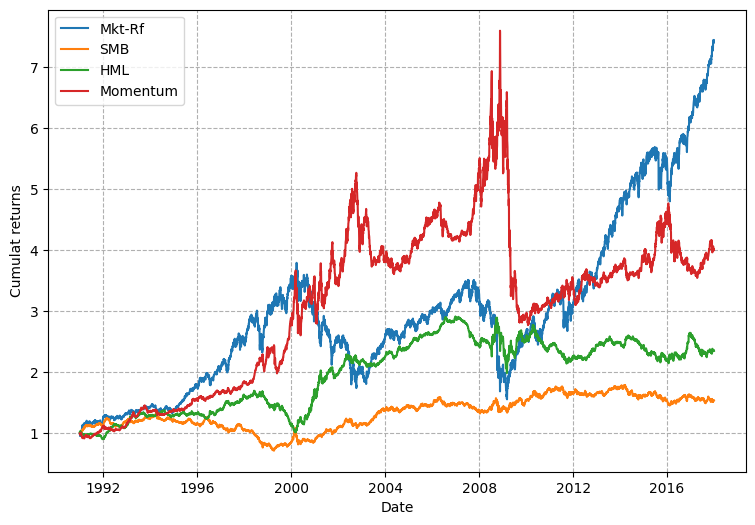

In [8]:
# plot directly from panda dataframe X_df
Factors = X_df.iloc[:, :4]

plt.figure(figsize=(9, 6))
plt.plot((1 + Factors).cumprod())
plt.legend(["Mkt-Rf", "SMB", "HML", "Momentum"])
plt.grid('on', linestyle = '--')

plt.xlabel('Date')
plt.ylabel('Cumulat returns')

### 1/N portfolio 
+ All risky assets


In [9]:
# Load momentum portfolio data
returns = pd.read_csv("data/10_Portfolios_mom.csv", parse_dates = [0], index_col = 0)
returns.index = pd.to_datetime(returns.index, format = '%Y%m%d')
row_num = returns.shape[1]

# convert % unit to decimal places
returns = returns / 100.

# weight vector w, 1 / N
w = np.full(row_num, np.double(1. / row_num))

# compute the excess returns, w^T * r
one_N = []
for date in returns.index:
    one_N.append([
        np.dot(w, returns.loc[date].values), w.tolist()
    ])
one_N = pd.DataFrame(one_N, index = returns.index, columns = ['one_N_excess_return', 'one_N_weight'])

# Load daily risk free returns
risk_free = pd.read_csv("data/risk-free_rate.csv", parse_dates = [0], index_col = 0)
risk_free = risk_free['RF'].to_frame()
risk_free.index = pd.to_datetime(risk_free.index, format = '%Y%m%d')
risk_free = risk_free / 100.
risk_free = risk_free[~risk_free.isna().any(axis = 1)]
risk_free = risk_free[risk_free.index.isin(one_N.index)]

# compute the return = excess return + risk_free return
one_N_return = risk_free['RF'] + one_N['one_N_excess_return']
one_N_return = pd.DataFrame(one_N_return, index = returns.index, columns = ['one_N_return'])
one_N_return = one_N_return.join(one_N['one_N_weight'])
one_N_return = one_N_return[one_N_return.index.isin(X_df.index)]

# test dataset
one_N_return_test = one_N_return[one_N_return.index.isin(factors_test.index)]
# one_N_return_test["one_N_return"].plot()
# plt.plot((1 + one_N_return["one_N_return"]).cumprod())
one_N_test_mean = one_N_return_test['one_N_return'].mean()
one_N_test_var = one_N_return_test['one_N_return'].var()
print(f"one_N_test_mean is {one_N_test_mean}")
print(f"one_N_test_var is {one_N_test_var}")

# certainty equivalent return
def cer(mean, var, gamma = 5):
    cer_1_N = mean - (gamma / 2) * var
    return cer_1_N
cer_1_N_test = cer(one_N_test_mean, one_N_test_var)
print(f"certainty equivalent return of 1/N in test is {cer_1_N_test * 1e4: .3f} (basis point)")



one_N_test_mean is 0.0006206046141607
one_N_test_var is 6.993602240485147e-05
certainty equivalent return of 1/N in test is  4.458 (basis point)


### Mean-variance portfolio

In [10]:
# trailing mean & variance
M = 240 
# risk aversion gamma
gamma = 5

# Load momentum portfolio data
returns = pd.read_csv("data/10_Portfolios_mom.csv", parse_dates = [0], index_col = 0)
returns.index = pd.to_datetime(returns.index, format = '%Y%m%d')

# convert % unit to decimal places
returns = returns / 100.

returns = returns[~returns.isna().any(axis = 1)]

# extract train_val_test period from returns
returns_period = returns[returns.index.isin(one_N_return.index)]

# extract trailing 240 days for computing mu & var
returns_left = returns[returns.index < one_N_return.index.min()][-M:]

# concat period with left
returns = pd.concat([returns_left, returns_period], axis = 0)

# compute mean from trailing window
def mean(return_win):
    """
    return_win : pd.dataframe
    """
    m = np.array(return_win.mean(), dtype = np.double)
    return m 

# compute covariance matrix from trailing window
def cov(return_win, mean):
    """
    return_win : pd.dataframe
    """
    cov_mat = np.zeros((return_win.shape[1], return_win.shape[1]))
    for _, row in return_win.iterrows():
        row = np.array(row, dtype = np.double)
        cov_mat += np.outer( (row - mean), (row - mean) )
    cov_mat /= return_win.shape[0]
    return cov_mat

# compute the excess returns for M-V portfolio
M_V = []
for date in returns_period.index:
    # compute mean & variance using trailing window
    return_win = returns[returns.index < date][-M:]
    mm = mean(return_win)
    cov_mat = cov(return_win, mm)
    # do not compute the weights by formula, 
    # w = (1 / gamma) * np.linalg.inv(cov_mat) @ mm

    # compute the weights by cvxpy, allow for short-sale
    w = cp.Variable(return_win.shape[1])
    g = cp.Parameter(nonneg = True)
    ret = mm.T @ w
    risk = (1 / 2) * cp.quad_form(w, cov_mat)
    prob = cp.Problem(cp.Maximize(ret - g * risk), [cp.sum(w) == 1., cp.abs(w) <= 1])
    # prob = cp.Problem(cp.Maximize(ret - g * risk), [cp.sum(w) == 1.])
    g.value = gamma
    prob.solve()
    w = w.value

    # append the return and corresponding weights
    M_V.append([
        np.dot(w, returns.loc[date].values), w.tolist()
    ])
M_V = pd.DataFrame(M_V, index = returns_period.index, columns = ['M_V_excess_return', 'M_V_weight'])



In [11]:
a = M_V["M_V_weight"][300:350].values.tolist()
a = np.array(a)
a = np.where(np.abs(a) < 1e-4, 0, a)
a




array([[-1.00000003,  1.00000038,  0.13427844,  0.99999933, -0.99999953,
        -0.99999897,  0.86572126, -1.00000327,  1.000003  ,  0.99999938],
       [-1.00000005,  0.93552922,  0.32281585,  1.00000202, -0.99999965,
        -1.00000134,  0.74165486, -1.00000291,  1.00000231,  0.99999969],
       [-0.99999985,  0.79582277,  0.27606852,  1.00000068, -0.99999809,
        -1.00000279,  0.92810871, -1.00000043,  1.00000034,  1.00000013],
       [-0.99999982,  0.66888171,  0.331118  ,  1.00000108, -0.99999782,
        -1.00000382,  1.00000039, -0.99999977,  0.99999986,  1.00000021],
       [-0.99999916,  0.14278083,  0.85721918,  0.99999688, -0.99999591,
        -1.00000675,  1.00000725, -1.00000093,  0.99999822,  1.00000039],
       [-1.        ,  0.        ,  1.        ,  1.        , -1.        ,
        -1.        ,  1.        , -1.        ,  1.        ,  1.        ],
       [-0.99999906,  0.27177366,  0.72822633,  0.99999664, -0.99999591,
        -1.00000761,  1.00000927, -1.00000183

In [12]:
# compute the return = excess return + risk_free return
M_V_return = risk_free['RF'] + M_V['M_V_excess_return']
M_V_return = pd.DataFrame(M_V_return, index = returns_period.index, columns = ['M_V_return'])
M_V_return = M_V_return.join(M_V['M_V_weight'])

M_V_return.head(10)

# test dataset
M_V_return_test = M_V_return[M_V_return.index.isin(factors_test.index)]
M_V_test_mean = M_V_return_test['M_V_return'].mean()
M_V_test_var = M_V_return_test['M_V_return'].var()
print(f"M_V_return_test_mean is {M_V_test_mean}")
print(f"M_V_return_test_var is {M_V_test_var}")

cer_M_V_test = cer(M_V_test_mean, M_V_test_var)
print(f"certainty equivalent return of M-V in test is {cer_M_V_test * 1e4: .3f} (basis point)")

M_V_return_test_mean is 0.00018388983875779064
M_V_return_test_var is 0.00020762396390084894
certainty equivalent return of M-V in test is -3.352 (basis point)


# Plotting

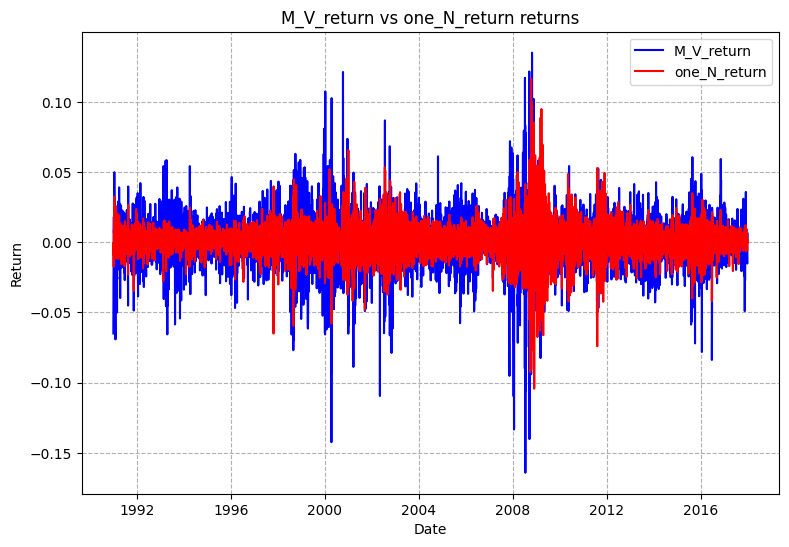

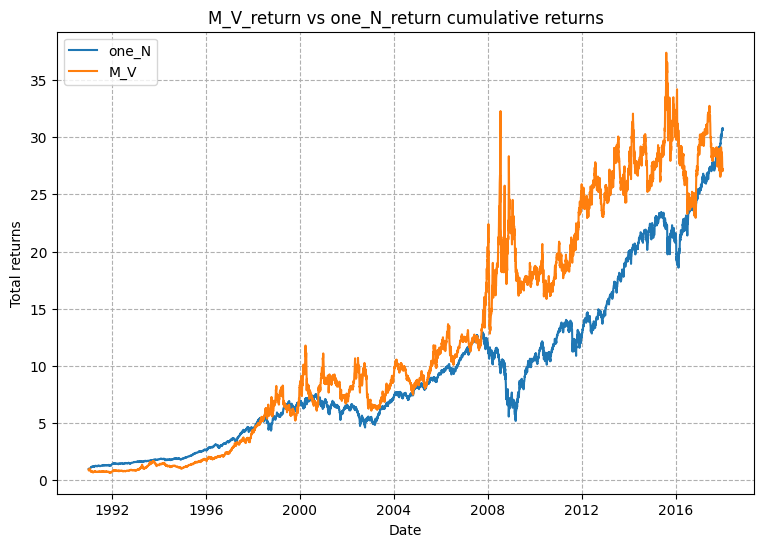

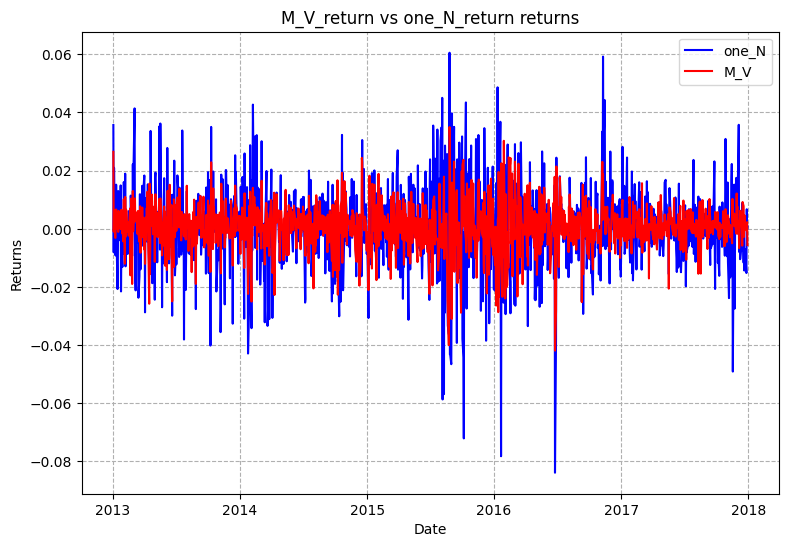

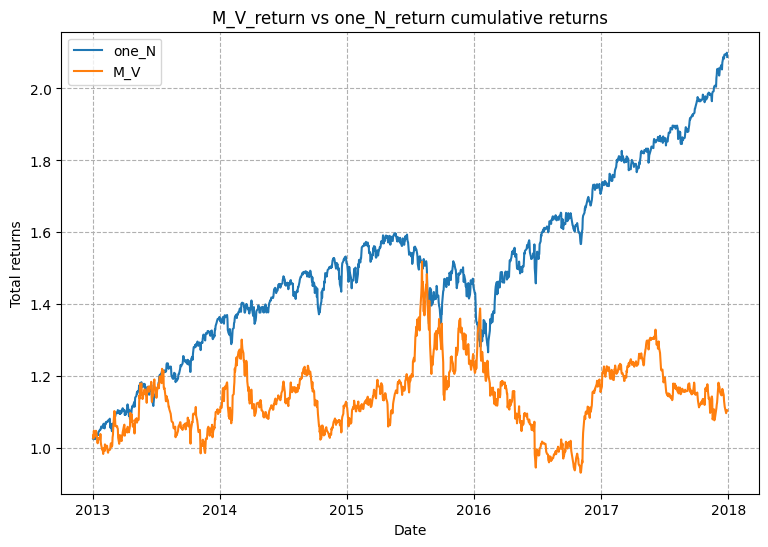

In [13]:
# # plot the correlation matrix
# import seaborn as sns
# plt.figure(figsize=(5, 3))
# sns.heatmap(np.corrcoef(cov_mat), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
# plt.title('Covariance Matrix')
# plt.xlabel('Stocks')
# plt.ylabel('Stocks')
# plt.show()

# plot of the returns
plt.figure(figsize=(9, 6))
plt.plot(M_V_return.index, M_V_return['M_V_return'], label='M_V_return', color='blue')
plt.plot(one_N_return.index, one_N_return['one_N_return'], label='one_N_return', color='red')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('M_V_return vs one_N_return returns')
plt.grid('on', linestyle = '--')
plt.legend()
plt.show()

# plot of the cumulative returns
plt.figure(figsize=(9, 6))
plt.plot((1 + one_N_return["one_N_return"]).cumprod())
plt.plot((1 + M_V_return['M_V_return']).cumprod())
plt.grid('on', linestyle = '--')
plt.title('M_V_return vs one_N_return cumulative returns')
plt.xlabel('Date')
plt.ylabel('Total returns')
plt.legend(["one_N", "M_V"])
plt.show()

# plot of the returns in the test period
plt.figure(figsize=(9, 6))
plt.plot(M_V_return_test.index, M_V_return_test['M_V_return'], label='M_V_return', color='blue')
plt.plot(one_N_return_test.index, one_N_return_test['one_N_return'], label='one_N_return', color='red')
plt.grid('on', linestyle = '--')
plt.title('M_V_return vs one_N_return returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(["one_N", "M_V"])
plt.show()

# plot of the cumulative returns in the test period
plt.figure(figsize=(9, 6))
plt.plot((1 + one_N_return_test["one_N_return"]).cumprod())
plt.plot((1 + M_V_return_test['M_V_return']).cumprod())
plt.grid('on', linestyle = '--')
plt.title('M_V_return vs one_N_return cumulative returns')
plt.xlabel('Date')
plt.ylabel('Total returns')
plt.legend(["one_N", "M_V"])
plt.show()


# Observations
- The correlation between 1/N and MV is not at all close to 1. sometimes it is positively correlated. sometimes it is negatively correlated. I think it very much depends on the market environment. Task: plot the dates when two are positively correlated. plot the dates when two are negatively correlated.
- The MV is much more volatile than the 1/N
- Before test period, the MV can sometime achieve amazing returns. But in the test period, it is completely doing negative return in the long run while the average returns of the 10 portfolios are positive. Complete negative correlation with the one_N in the test period. Task: try different delta values to combine those two to see the corresponding return in the test period

- Try all long portfolio
- solely plot the return in a smaller period
- penelize m-v mean, set the 1/n as the main tune
- dynamic delta
- predict returns of a and b + positive or negative correlation between a and b (predict the volatility of a and b + sign of b(1/n) + correlation of a and b)

Thoughts:
- Why do we need covariance?
    - one is that, we can construct a quadratic form of the delta, ***check the validity of the method
    - Two is that, maybe predicting covariance (correlation) can help model predict the returns of a and b jointly more precisely 
- correlation prediction problem
    - Add a covariance predictor to the return predictor. Do incremental learning of three outputs, fine-tune on the two returns in online stage
    - penelize the loss function if the sign is wrong
    - maybe correlation is not needed, just maybe sign matters more
- variance prediction problem
    - *** check whether the scale term is really the conditional variance
    - x vector distance to prototype vector
    - shrinkage estimate of both prototype vector and time series estimator






In [16]:
# # compute the correlation between 1/n and mv
# corr = one_N_return["one_N_return"].corr(M_V_return['M_V_return'])
# corr

# # compute the correlation in different periods

one_N_return["one_N_return_20"] = one_N_return["one_N_return"].rolling(20).mean()
M_V_return["M_V_return_20"] = M_V_return["M_V_return"].rolling(20).mean()

one_N_return_test["one_N_return_20"] = one_N_return_test["one_N_return"].rolling(20).mean()
M_V_return_test["M_V_return_20"] = M_V_return_test["M_V_return"].rolling(20).mean()


def corr_plot(a, b, win=40):
    """corr_compute"""
    corr_signs = (a * b > 0).astype(int)
    corr_df = pd.DataFrame(corr_signs, index = a.index, columns = ['corr_signs'])
    for date in a.index[win:]:
        array1 = a[a.index < date][-win:]
        array2 = b[b.index < date][-win:]
        corr = array1.corr(array2)
        corr_df.loc[date, 'corr_rolling'] = corr
    corr_df["corr_rolling"] = corr_df["corr_rolling"].shift( int(-win / 2) )
    return corr_df["corr_rolling"]

def var_plot(a, win=20):
    """var_compute"""
    var_df = pd.DataFrame(index = a.index)
    for date in a.index[win:]:
        array = a[a.index < date][-win:]
        var = array.var()
        var_df.loc[date, 'var_rolling'] = var
    var_df["var_rolling"] = var_df["var_rolling"].shift( int(-win / 2) )
    return var_df["var_rolling"]

# the corr plot with non-trailing return is useless
# corr_series = corr_plot(one_N_return["one_N_return"], M_V_return['M_V_return'], win=60)
# corr_s_test = corr_plot(M_V_return_test['M_V_return'], one_N_return_test['one_N_return'], win=60)

corr_20 = corr_plot(one_N_return["one_N_return_20"], M_V_return['M_V_return_20'])
corr_test_20 = corr_plot(M_V_return_test['M_V_return_20'], one_N_return_test['one_N_return_20'])

a_var = var_plot(one_N_return_test["one_N_return"], win=40)
b_var = var_plot(M_V_return_test['M_V_return'], win=40)



/var/folders/k5/yd970r0n4z3137g3zxnwm9sr0000gn/T/ipykernel_65968/4156555367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_N_return_test["one_N_return_20"] = one_N_return_test["one_N_return"].rolling(20).mean()
/var/folders/k5/yd970r0n4z3137g3zxnwm9sr0000gn/T/ipykernel_65968/4156555367.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M_V_return_test["M_V_return_20"] = M_V_return_test["M_V_return"].rolling(20).mean()


In [17]:
# correlation plot for train + val + test
plt.figure(figsize=(10, 6))  
for date, corr in corr_series.items():
    if corr > 0:
        plt.vlines(x=date, ymin=0, ymax=10 * corr, color='r')  # Positive value, plot a red vertical line
    else:
        plt.vlines(x=date, ymin=10 * corr, ymax=0, color='g')  # Negative value, plot a green vertical line
plt.plot((1 + one_N_return["one_N_return"]).cumprod())
plt.plot((1 + M_V_return['M_V_return']).cumprod())
plt.grid('on', linestyle = '--')

plt.title('Correlation Rolling Plot')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()

# # correlation plot for test
# plt.figure(figsize=(10, 6))  
# for date, corr in corr_s_test.items():
#     if corr > 0:
#         plt.vlines(x=date, ymin=0, ymax=corr, color='r')  # Positive value, plot a red vertical line
#     else:
#         plt.vlines(x=date, ymin=corr, ymax=0, color='g')  # Negative value, plot a green vertical line
# plt.plot((1 + M_V_return_test['M_V_return']).cumprod())
# plt.plot((1 + one_N_return_test['one_N_return']).cumprod())
# plt.grid('on', linestyle = '--')

# plt.title('Correlation Rolling Plot')
# plt.xlabel('Date')
# plt.ylabel('Correlation')
# plt.show()

# # corr plot for 90 day win, 20 day trailing mean
# plt.figure(figsize=(10, 6))  
# for date, corr in corr_20.items():
#     if corr > 0:
#         plt.vlines(x=date, ymin=0, ymax=10 * corr, color='r')  # Positive value, plot a red vertical line
#     else:
#         plt.vlines(x=date, ymin=10 * corr, ymax=0, color='g')  # Negative value, plot a green vertical line
# plt.plot((1 + one_N_return["one_N_return"]).cumprod())
# plt.plot((1 + M_V_return['M_V_return']).cumprod())
# plt.grid('on', linestyle = '--')

# plt.title('Correlation Rolling Plot')
# plt.xlabel('Date')
# plt.ylabel('Correlation')
# plt.show()

# corr test plot for 90 day win, 20 day trailing mean
plt.figure(figsize=(10, 6))  
for date, corr in corr_test_20.items():
    if corr > 0:
        plt.vlines(x=date, ymin=0, ymax=corr, color='r', linestyles='dotted')  # Positive value, plot a red vertical line
    else:
        plt.vlines(x=date, ymin=corr, ymax=0, color='g', linestyles='dotted')  # Negative value, plot a green vertical line
plt.plot((1 + M_V_return_test['M_V_return']).cumprod())
plt.plot((1 + one_N_return_test['one_N_return']).cumprod())
plt.grid('on', linestyle = '--')

plt.title('Correlation Rolling Plot')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()

# 1/n var test plot for 20 day win
plt.figure(figsize=(10, 6))  
for date, var in a_var.items():
    plt.vlines(x=date, ymin=0, ymax=var, color='r', linestyles='dotted')
# plt.plot((1 + one_N_return_test['one_N_return']).cumprod())
plt.grid('on', linestyle = '--')
plt.title('1/N var Plot')
plt.xlabel('Date')
plt.ylabel('var (bp)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e4))) 
plt.show()

# # var test plot for 20 day win, 20 day rolling 
# plt.figure(figsize=(10, 6))  
# for date, var in a_var_20.items():
#     plt.vlines(x=date, ymin=0, ymax=var, color='r', linestyles='dotted')
# # plt.plot((1 + one_N_return_test['one_N_return']).cumprod())
# plt.grid('on', linestyle = '--')
# plt.title('1/N var Plot')
# plt.xlabel('Date')
# plt.ylabel('var (bp)')
# # plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e4))) 
# plt.show()

# m-v var test plot for 20 day win
plt.figure(figsize=(10, 6))  
for date, var in b_var.items():
    plt.vlines(x=date, ymin=0, ymax=var, color='r', linestyles='dotted')
# plt.plot((1 + one_N_return_test['one_N_return']).cumprod())
plt.grid('on', linestyle = '--')
plt.title('M-V var Plot')
plt.xlabel('Date')
plt.ylabel('var (bp)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e4))) 
plt.show()



NameError: name 'corr_series' is not defined

<Figure size 1000x600 with 0 Axes>

# Verify whether quadractic form makes sense

In [ ]:
# Perfect information case

# return is predicted with some pertubation
info = pd.DataFrame()

# 1/n, mean: 6.2bp, var: 0.69bp, noise_var: 0.5bp
print(f"one_N port has mean {one_N_return_test['one_N_return'].mean() * 1e4: .3f}bp, var {one_N_return_test['one_N_return'].var()* 1e4: .3f}bp")
# m-v (abs=1), mean: 1.8bp, var: 2.0bp
print(f"m-v port has mean {M_V_return_test['M_V_return'].mean()* 1e4: .3f}bp, var {M_V_return_test['M_V_return'].var()* 1e4: .3f}bp")

np.random.seed(99)
noise_1 = np.random.normal(loc = 0., scale = 7e-3, size = len(one_N_return_test["one_N_return"]))
np.random.seed(100)
noise_2 = np.random.normal(loc = 0., scale = 7e-3, size = len(M_V_return_test["M_V_return"]))
info["one_N_return_hat"] = one_N_return_test["one_N_return"] + noise_1
info["M_V_return_hat"] = M_V_return_test["M_V_return"] + noise_2

## Long term correlation estimation: corr: (40, 20), var: (20)
# variance estimation with 20 day window
info["one_N_return_var"] = a_var
info["M_V_return_var"] = b_var

# correlation estimation with 40 day window, 20 day rolling mean
info["corr"] = corr_test_20
info = info[~info.isna().any(axis = 1)]

def perf_prediction(info, gam):
    result = []
    for date in info.index:
        r1 = info.loc[date]["one_N_return_hat"]
        r2 = info.loc[date]["M_V_return_hat"]
        cv00 = info.loc[date]["one_N_return_var"]
        cv11 = info.loc[date]["M_V_return_var"]
        cv01 = info.loc[date]["corr"] * np.sqrt(cv00) * np.sqrt(cv11)
        cv10 = info.loc[date]["corr"] * np.sqrt(cv00) * np.sqrt(cv11)

        mean = np.array([r1, r2])
        cov_mat = np.array([[cv00, cv01],
                            [cv10, cv11]])
        w = cp.Variable(cov_mat.shape[1])
        g = cp.Parameter(nonneg = True)
        ret = mean.T @ w
        risk = (1 / 2) * cp.quad_form(w, cov_mat)
        prob = cp.Problem(cp.Maximize(ret - g * risk), [cp.sum(w) == 1, w >= 0])
        g.value = gam
        prob.solve()
        w = w.value
        
        true_mean = np.array([one_N_return_test["one_N_return"].loc[date],
                              M_V_return_test["M_V_return"].loc[date]
                              ])
        r = true_mean.T @ w
        result.append([w[0], r])
    
    result = pd.DataFrame(result, index = info.index, columns = ["delta", "joint_return"])
    return result

result = perf_prediction(info, 500)

# long-term variance / short-term variance
# 1. long-term variance + long-term correlation
# 2. short-term variance + short-term correlation



In [ ]:
c1 = result["delta"]
c1 = np.round(c1, 4)
print(c1[30:60])

# compute the combined weights
w1 = one_N_return_test["one_N_weight"]
w1 = w1[w1.index.isin(c1.index)]

w2 = M_V_return_test["M_V_weight"]
w2 = w2[w2.index.isin(c1.index)]

w_j = []
for date in c1.index:
    ww1 = np.array( w1.loc[date] )
    ww2 = np.array( w2.loc[date] )
    delta = c1.loc[date]
    joint_w = (ww1 * delta + ww2 * (1 - delta)).tolist()
    w_j.append(joint_w)
w_j = np.array(w_j)
s = np.sum(w_j, axis=1)

c2 = result["joint_return"]
c2_mean = c2.mean()
c2_var = c2.var()

print(f"joint_port has return mean {c2.mean() * 1e4: .4f}bp, return var {c2.var() * 1e4: .4f}bp")

plt.figure(figsize=(10, 6))  
for date, corr in corr_test_20.items():
    if corr > 0:
        plt.vlines(x=date, ymin=0, ymax=corr, color='r', linestyles='dotted')  # Positive value, plot a red vertical line
    else:
        plt.vlines(x=date, ymin=corr, ymax=0, color='g', linestyles='dotted')  # Negative value, plot a green vertical line
plt.plot(np.log((1 + M_V_return_test['M_V_return']).cumprod()))
plt.plot(np.log((1 + one_N_return_test['one_N_return']).cumprod()))
plt.plot(np.log((1 + result["joint_return"]).cumprod()))
plt.grid('on', linestyle = '--')
plt.title('Correlation Rolling Plot')
plt.xlabel('Date')
plt.ylabel('Total return (log)')
plt.show()

# 1. adjust the risk aversion
# 2. get the weights




In [ ]:
date = info.index[3]

info.loc[date]["one_N_return_hat"]

# How is the data pre-processed in the meta-learning
# Their dataset
- Alpha158 : CSI 300 data
- Alpha360 : China's A share stock

In [ ]:
# M = 240 days 
# gamma = 5










